## Load the data:

In [1]:
import warnings
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Suppress specific UserWarnings from openpyxl
warnings.filterwarnings("ignore", category=UserWarning, module='openpyxl')

# Define the directory where your files are located
# data_dir = '.'  
data_dir = os.path.join(os.path.pardir) 

# List to hold the dataframes
dataframes = []

# Loop through the years and load the files
for year in range(2005, 2020):
    if year <= 2012:
        file_path = os.path.join(data_dir, f'{year}.xls')
    else:
        file_path = os.path.join(data_dir, f'{year}.xlsx')

    # Load the file into a dataframe
    df = pd.read_excel(file_path)

    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the dataframes into one
betting_data = pd.concat(dataframes, ignore_index=True)


## Fixing Anomalies

In [2]:
def is_column_numeric(df, column_name):
    # Check if the column contains only numeric values
    return df[column_name].apply(lambda x: str(x).isnumeric()).all()

# Check if columns are numeric before converting
anomaly_column = ['WRank', 'LRank', 'EXW']
for column in anomaly_column:
    if is_column_numeric(betting_data, column):
        print(f"Column '{column}' is numeric.\n")
    else:
        print(f"Column '{column}' is not numeric.\n")

def find_non_numeric_values(df, column_name):
    # Function to check if a value is numeric
    def is_numeric(value):
        try:
            float(value)
            return True
        except ValueError:
            return False

    # Apply the function to the column and filter non-numeric values
    non_numeric_values = df[~df[column_name].apply(is_numeric)]

    # Display the non-numeric values
    print(f"Non-numeric values in {column_name}:")
    print(non_numeric_values[[column_name]], "\n")

# WRank column
find_non_numeric_values(betting_data, 'WRank')

# LRank column
find_non_numeric_values(betting_data, 'LRank')

# EXW column
find_non_numeric_values(betting_data, 'EXW')

Column 'WRank' is not numeric.

Column 'LRank' is not numeric.

Column 'EXW' is not numeric.

Non-numeric values in WRank:
Empty DataFrame
Columns: [WRank]
Index: [] 

Non-numeric values in LRank:
Empty DataFrame
Columns: [LRank]
Index: [] 

Non-numeric values in EXW:
        EXW
23776  2.,3 



In [3]:
# Convert WRank and LRank to numeric, coercing errors
betting_data['WRank'] = pd.to_numeric(betting_data['WRank'], errors='coerce')
betting_data['LRank'] = pd.to_numeric(betting_data['LRank'], errors='coerce')

# Fill NaN values with a high number
betting_data['WRank'].fillna(100000, inplace=True)
betting_data['LRank'].fillna(100000, inplace=True)


# Correct the typo in row 38294, column 'EXW'
if betting_data.at[38294, 'EXW'] == '2.,3':
    betting_data.at[38294, 'EXW'] = '2.3'


## Feature Engineering:

In [4]:
# Now perform the calculations
betting_data['higher_rank_won'] = (betting_data['WRank'] < betting_data['LRank']).astype(int)
betting_data['higher_rank_points'] = betting_data['higher_rank_won'] * betting_data['WPts'] + betting_data['LPts'] * (1 - betting_data['higher_rank_won'])
betting_data['lower_rank_points'] = (1 - betting_data['higher_rank_won']) * betting_data['WPts'] + betting_data['LPts'] * betting_data['higher_rank_won']
betting_data['higher_rank_points'].fillna(0, inplace=True)
betting_data['lower_rank_points'].fillna(0, inplace=True)

all_matches_538 = betting_data.copy()
# Columns to drop
# columns_to_drop = [
#     'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'Comment',
#     'CBW', 'CBL', 'GBW', 'GBL', 'IWW', 'IWL', 'SBW', 'SBL', 'B365W', 'B365L', 'B&WW', 'B&WL',
#     'EXW', 'EXL', 'PSW', 'PSL', 'WPts', 'LPts', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL',
#     'MaxW', 'MaxL', 'AvgW', 'AvgL'
# ]

columns_to_drop = [
    'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'Comment',
    'CBW', 'CBL', 'IWW', 'IWL', 'B365W', 'B365L', 
    'EXW', 'EXL', 'PSW', 'PSL', 'WPts', 'LPts', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL',
    'MaxW', 'MaxL', 'AvgW', 'AvgL'
]

# Drop the columns
all_matches_538 = all_matches_538.drop(columns=columns_to_drop)

In [5]:
all_matches_538

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,higher_rank_won,higher_rank_points,lower_rank_points
0,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Saulnier C.,Baccanello P.,53.0,324.0,1,0.0,0.0
1,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,Sluiter R.,72.0,82.0,1,0.0,0.0
2,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Melzer J.,Berdych T.,39.0,45.0,1,0.0,0.0
3,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Rochus O.,Dupuis A.,66.0,79.0,1,0.0,0.0
4,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Mayer F.,Arthurs W.,35.0,101.0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40385,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Nadal R.,Tsitsipas S.,1.0,6.0,1,9585.0,4000.0
40386,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Zverev A.,Medvedev D.,7.0,4.0,0,5705.0,2945.0
40387,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Tsitsipas S.,Federer R.,6.0,3.0,0,6190.0,4000.0
40388,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Thiem D.,Zverev A.,5.0,7.0,1,5025.0,2945.0


## ELO Setup:

### Model Simulation

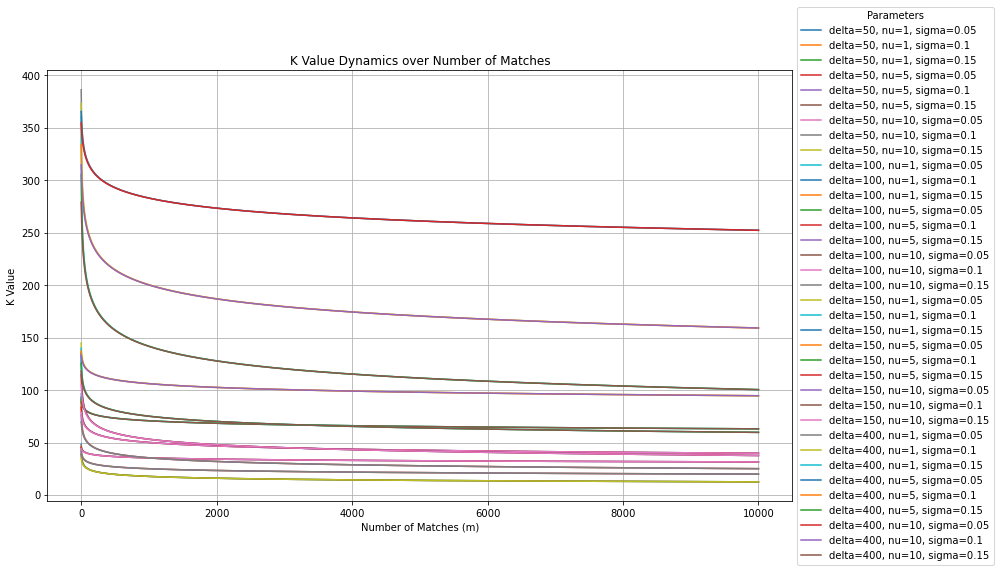

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Define the parameter grid for the FiveThirtyEight model
param_grid = {
    'delta': [50, 100, 150, 400],
    'nu': [1, 5, 10],
    'sigma': [0.05, 0.1, 0.15]
}

# Sequence of matches
m = np.arange(1, 10001)

# Initialize a DataFrame to store results
results = []

# Iterate over all parameter combinations
for delta, nu, sigma in product(param_grid['delta'], param_grid['nu'], param_grid['sigma']):
    # Calculate K values for FiveThirtyEight model
    K_FTE = delta / (m + nu) ** sigma

    # Store results in a DataFrame
    df = pd.DataFrame({
        'm': m,
        'K_FTE': K_FTE,
        'delta': delta,
        'nu': nu,
        'sigma': sigma
    })
    results.append(df)

# Concatenate all results into a single DataFrame
all_results = pd.concat(results)

# Plot the K values for different parameter combinations
plt.figure(figsize=(14, 8))
for (delta, nu, sigma), group in all_results.groupby(['delta', 'nu', 'sigma']):
    label = f'delta={delta}, nu={nu}, sigma={sigma}'
    plt.plot(group['m'], group['K_FTE'], label=label)

plt.xlabel('Number of Matches (m)')
plt.ylabel('K Value')
plt.title('K Value Dynamics over Number of Matches')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Parameters")
plt.grid(True)
plt.tight_layout()
plt.show()


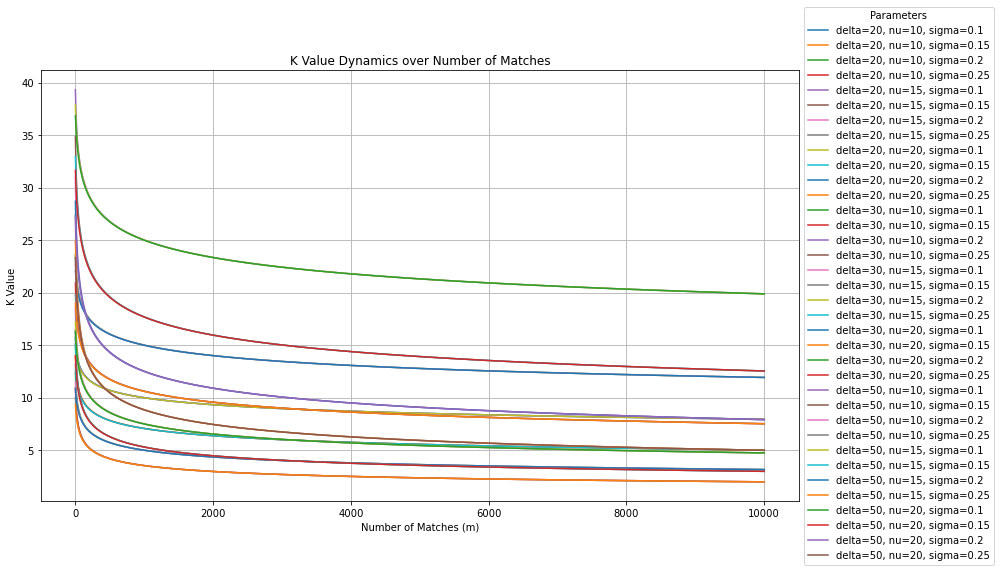

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Define the parameter grid for the FiveThirtyEight model
param_grid = {
    'delta': [20, 30, 50],
    'nu': [10, 15, 20],
    'sigma': [0.1, 0.15, 0.20, 0.25]
}

# Sequence of matches
m = np.arange(1, 10001)

# Initialize a DataFrame to store results
results = []

# Iterate over all parameter combinations
for delta, nu, sigma in product(param_grid['delta'], param_grid['nu'], param_grid['sigma']):
    # Calculate K values for FiveThirtyEight model
    K_FTE = delta / (m + nu) ** sigma

    # Store results in a DataFrame
    df = pd.DataFrame({
        'm': m,
        'K_FTE': K_FTE,
        'delta': delta,
        'nu': nu,
        'sigma': sigma
    })
    results.append(df)

# Concatenate all results into a single DataFrame
all_results = pd.concat(results)

# Plot the K values for different parameter combinations
plt.figure(figsize=(14, 8))
for (delta, nu, sigma), group in all_results.groupby(['delta', 'nu', 'sigma']):
    label = f'delta={delta}, nu={nu}, sigma={sigma}'
    plt.plot(group['m'], group['K_FTE'], label=label)

plt.xlabel('Number of Matches (m)')
plt.ylabel('K Value')
plt.title('K Value Dynamics over Number of Matches')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Parameters")
plt.grid(True)
plt.tight_layout()
plt.show()


## GridSearch - 538 Model

In [8]:
# ELO Setup
initial_elo = 1500
players_elo = {}

def win_probability(E_i, E_j):
    return 1 / (1 + 10 ** ((E_j - E_i) / 400))

def get_player_elo(player_name):
    if player_name not in players_elo:
        players_elo[player_name] = initial_elo
    return players_elo[player_name]

def set_player_elo(player_name, elo):
    players_elo[player_name] = elo

players_games_played = {}

def get_games_played(player_name):
    if player_name not in players_games_played:
        players_games_played[player_name] = 0
    return players_games_played[player_name]

def increment_games_played(player_name):
    players_games_played[player_name] = players_games_played.get(player_name, 0) + 1

def update_elo_538(E_i, E_j, outcome, games_played_i):
    K = 100 / (games_played_i + 10) ** 0.15
    pi_j = win_probability(E_i, E_j)  # Calculate win probability for player i against player j
    if outcome == 'win':
        delta_E_i = K * (1 - pi_j)  # Elo rating change for a win
        new_E_i = E_i + delta_E_i
    elif outcome == 'loss':
        delta_E_i = K * (pi_j - 1)  # Elo rating change for a loss
        new_E_i = E_j + delta_E_i
    else:
        raise ValueError("Outcome must be 'win' or 'loss'")
    return new_E_i


In [9]:
# Define the parameter grid for the FiveThirtyEight model
# param_grid = {
#     'delta': [120, 125, 130, 150, 180],
#     'nu': [15, 20, 25, 30, 35],
#     'sigma': [0.20, 0.25, 0.30, 0.35, 0.40]
# }

# param_grid = {
#     'delta': list(range(20, 200, 20)),
#     'nu': list(range(15, 40, 5)),
#     'sigma': [x / 100 for x in range(20, 45, 5)]
# }

param_grid = {
    'delta': list(range(10, 150, 5)),
    'nu': list(range(10, 50, 5)),
    'sigma': [x / 100 for x in range(15, 55, 5)]
}


def evaluate_model(df):
    logloss_value = log_loss(df.higher_rank_won, df.prob_high_ranked)
    accuracy_value = np.mean(df.match_outcome == df.higher_rank_won)
    calibration_value = np.sum(df.prob_high_ranked) / np.sum(df.higher_rank_won)
    return logloss_value, accuracy_value, calibration_value

results = []

def update_elo_538_param(E_i, E_j, outcome, games_played_i, delta, nu, sigma):
    K = delta / (games_played_i + nu) ** sigma
    pi_j = win_probability(E_i, E_j)  # Calculate win probability for player i against player j
    if outcome == 'win':
        delta_E_i = K * (1 - pi_j)  # Elo rating change for a win
        new_E_i = E_i + delta_E_i
    elif outcome == 'loss':
        delta_E_i = K * (pi_j - 1)  # Elo rating change for a loss
        new_E_i = E_j + delta_E_i
    else:
        raise ValueError("Outcome must be 'win' or 'loss'")
    return new_E_i


def update_elo_and_probabilities_538_param(df, delta, nu, sigma):
    for index, match in df.iterrows():
        winner_name, loser_name = match['Winner'], match['Loser']

        # Retrieve current Elo ratings
        winner_elo = get_player_elo(winner_name)
        loser_elo = get_player_elo(loser_name)

        # Store initial Elo ratings
        df.at[index, 'winner_initial_elo'] = winner_elo
        df.at[index, 'loser_initial_elo'] = loser_elo

        # Get the number of games played by each player
        games_played_winner = get_games_played(winner_name)
        games_played_loser = get_games_played(loser_name)

        # Calculate win probabilities
        df.at[index, 'prob_winner'] = win_probability(winner_elo, loser_elo)

        # Determine match outcomes based on probability and who was expected to win
        if match['higher_rank_won']:
            df.at[index, 'match_outcome'] = int(df.at[index, 'prob_winner'] > 0.5)
            df.at[index, 'prob_high_ranked'] = df.at[index, 'prob_winner']
        else:
            df.at[index, 'match_outcome'] = int((1 - df.at[index, 'prob_winner']) > 0.5)
            df.at[index, 'prob_high_ranked'] = 1 - df.at[index, 'prob_winner']

        # Update Elo ratings
        new_winner_elo = update_elo_538_param(winner_elo, loser_elo, 'win', games_played_winner, delta, nu, sigma)
        new_loser_elo = update_elo_538_param(winner_elo, loser_elo, 'loss', games_played_loser, delta, nu, sigma)
        set_player_elo(winner_name, new_winner_elo)
        set_player_elo(loser_name, new_loser_elo)

        # Store new Elo ratings
        df.at[index, 'winner_new_elo'] = new_winner_elo
        df.at[index, 'loser_new_elo'] = new_loser_elo

        # Increment the number of games played
        increment_games_played(winner_name)
        increment_games_played(loser_name)

# Update ELO ratings and probabilities for the entire dataset
for params in ParameterGrid(param_grid):
    players_elo = {}
    players_games_played = {}
    all_matches_538_elo = all_matches_538.copy()
    update_elo_and_probabilities_538_param(all_matches_538_elo, params['delta'], params['nu'], params['sigma'])
    all_matches_538_elo['Date'] = pd.to_datetime(all_matches_538_elo['Date'], format='%Y-%m-%d')
    split_time = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
    all_matches_538_elo_train = all_matches_538_elo[all_matches_538_elo['Date'] < split_time]
    all_matches_538_elo_validation = all_matches_538_elo[all_matches_538_elo['Date'] >= split_time]
    logloss_value, accuracy_value, calibration_value = evaluate_model(all_matches_538_elo_validation)
    results.append({
        'delta': params['delta'],
        'nu': params['nu'],
        'sigma': params['sigma'],
        'logloss': logloss_value,
        'accuracy': accuracy_value,
        'calibration': calibration_value
    })

results_df = pd.DataFrame(results)
best_params_logloss = results_df.loc[results_df['logloss'].idxmin()]
best_params_accuracy = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best parameters based on log-loss: \n{best_params_logloss}\n")
print(f"Best parameters based on accuracy: \n{best_params_accuracy}\n")

# # Prompt user for choice
# choice = input("Update Elo ratings based on (logloss/accuracy): ").strip().lower()

# if choice == "logloss":
#     best_params = best_params_logloss
# elif choice == "accuracy":
#     best_params = best_params_accuracy
# else:
#     raise ValueError("Invalid choice! Please choose 'logloss' or 'accuracy'.")

# print(f"Selected best parameters: \n{best_params}")



Best parameters based on log-loss: 
delta          120.000000
nu              25.000000
sigma            0.350000
logloss          0.633003
accuracy         0.630158
calibration      1.032392
Name: 1436, dtype: float64

Best parameters based on accuracy: 
delta          90.000000
nu             10.000000
sigma           0.200000
logloss         0.635936
accuracy        0.643270
calibration     1.051572
Name: 1025, dtype: float64



In [10]:
# Filter rows where accuracy is greater than 0.64
filtered_df_accuracy = results_df[results_df['accuracy'] > 0.641]

# Sort the filtered DataFrame by ascending order of log-loss
sorted_df_accuracy = filtered_df_accuracy.sort_values(by='logloss')

print(sorted_df_accuracy)


      delta  nu  sigma   logloss  accuracy  calibration
897      80  10   0.20  0.634663  0.641342     1.047379
1771    145  35   0.30  0.634967  0.642113     1.049578
1298    110  20   0.25  0.635092  0.642113     1.049667
1290    110  15   0.25  0.635259  0.641728     1.050232
961      85  10   0.20  0.635264  0.641342     1.049595
...     ...  ..    ...       ...       ...          ...
1425    120  20   0.20  0.640439  0.641342     1.059109
1521    125  40   0.20  0.640529  0.641728     1.058890
1417    120  15   0.20  0.640716  0.642499     1.059476
1505    125  30   0.20  0.640903  0.642113     1.059458
1497    125  25   0.20  0.641124  0.641342     1.059767

[88 rows x 6 columns]


In [24]:
# Filter rows where logloss is less than 0.633985 and accuracy is greater than 0.63
filtered_df_logloss = results_df[(results_df['logloss'] < 0.633985) & (results_df['accuracy'] > 0.63)]

# Sort the filtered DataFrame by ascending order of logloss
sorted_df_logloss = filtered_df_logloss.sort_values(by='logloss')

print(sorted_df_logloss.head())


      delta  nu  sigma   logloss  accuracy  calibration
1436    120  25   0.35  0.633003  0.630158     1.032392
1428    120  20   0.35  0.633016  0.630158     1.033303
1508    125  30   0.35  0.633017  0.630544     1.033582
1500    125  25   0.35  0.633025  0.630929     1.034417
1107     95  20   0.30  0.633032  0.631315     1.033501


In [12]:
# Get the first row of each dataframe
optimisation_1 = sorted_df_logloss.iloc[0]
optimisation_2 = sorted_df_accuracy.iloc[0]
optimisation_3 = sorted_df_accuracy.iloc[1]
optimisation_4 = sorted_df_accuracy.iloc[16]

# Combine the rows into a single dataframe for comparison
comparison_df = pd.DataFrame({
    'Optimisation 1': optimisation_1,
    'Optimisation 2': optimisation_2,
    'Optimisation 3': optimisation_3,
    'Optimisation 4': optimisation_4
}).T

print(comparison_df)


                delta    nu  sigma   logloss  accuracy  calibration
Optimisation 1  120.0  25.0   0.35  0.633003  0.630158     1.032392
Optimisation 2   80.0  10.0   0.20  0.634663  0.641342     1.047379
Optimisation 3  145.0  35.0   0.30  0.634967  0.642113     1.049578
Optimisation 4   90.0  10.0   0.20  0.635936  0.643270     1.051572


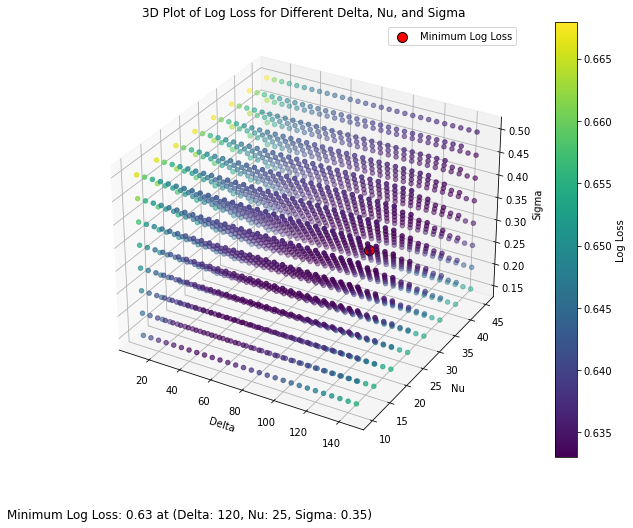

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Prepare data for 3D plot
X = results_df['delta']
Y = results_df['nu']
Z = results_df['sigma']
log_loss_values = results_df['logloss']

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create 3D scatter plot
sc = ax.scatter(X, Y, Z, c=log_loss_values, cmap='viridis', marker='o')

# Find the minimum log loss and its corresponding parameters
min_loss_index = np.argmin(log_loss_values)
min_X = X.iloc[min_loss_index]
min_Y = Y.iloc[min_loss_index]
min_Z = Z.iloc[min_loss_index]
min_loss = log_loss_values.iloc[min_loss_index]

# Highlight the minimum log loss point
ax.scatter(min_X, min_Y, min_Z, color='red', s=100, edgecolor='black', label='Minimum Log Loss')

# Add color bar which maps values to colors
cbar = plt.colorbar(sc)
cbar.set_label('Log Loss')

# Set labels and title
ax.set_xlabel('Delta')
ax.set_ylabel('Nu')
ax.set_zlabel('Sigma')
ax.set_title('3D Plot of Log Loss for Different Delta, Nu, and Sigma')

# Show legend
ax.legend()

# Add annotation outside the plot
plt.figtext(0.15, 0.02, f'Minimum Log Loss: {min_loss:.2f} at (Delta: {min_X}, Nu: {min_Y}, Sigma: {min_Z})', fontsize=12, ha='left')

plt.show()


In [15]:
# Update Elo ratings based on the selected best parameters
players_elo = {}
players_games_played = {}
# update_elo_and_probabilities_538_param(all_matches_538, best_params['delta'], best_params['nu'], best_params['sigma'])
update_elo_and_probabilities_538_param(all_matches_538, 120, 25, 0.35)

# # Optionally, update DataFrame with new Elo scores
# all_matches_538['winner_new_elo'] = all_matches_538['Winner'].apply(get_player_elo)
# all_matches_538['loser_new_elo'] = all_matches_538['Loser'].apply(get_player_elo)


## Split Dataset:

In [16]:

all_matches_538['Date'] = pd.to_datetime(all_matches_538['Date'], format='%Y-%m-%d')
split_time = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
all_matches_538_train = all_matches_538[all_matches_538['Date'] < split_time]
all_matches_538_validation = all_matches_538[all_matches_538['Date'] >= split_time]


## Evaluate Model Performance


In [17]:
def calculate_metrics(data):
    # Calculate accuracy
    accuracy = np.mean(data.match_outcome == data.higher_rank_won)
    print(f'Accuracy: {accuracy}')

    # Calculate calibration
    calibration = np.sum(data.prob_high_ranked) / np.sum(data.higher_rank_won)
    print(f'Calibration: {calibration}')

    # Define log loss function
    def logloss(actual, predictions):
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        
        log_loss_value = -(1 / len(actual)) * np.sum(
            actual * np.log(predictions) + (1 - actual) * np.log(1 - predictions))
        return log_loss_value

    # Calculate log loss
    log_loss_value = logloss(data.higher_rank_won, data.prob_high_ranked)
    print(f'Log Loss: {log_loss_value}')

    return accuracy, calibration, log_loss_value

# Example usage with a dataset
accuracy_538, calibration_538, log_loss_538 = calculate_metrics(all_matches_538_validation)


Accuracy: 0.630158118010027
Calibration: 1.0323923555883705
Log Loss: 0.6330033264851003


In [19]:
# Create a DataFrame with the selected metrics
metric_comparison = pd.DataFrame({
    'model': ['K_Constant', 'FiveThirtyEight_(538)', "538_Optimised"],
    'pred_acc': [0.629772, 0.635943, accuracy_538],
    'log_loss': [0.633985, 0.650521, log_loss_538],
    'calibration': [1.028118, 1.064329, calibration_538]
})

# Print the DataFrame
print(metric_comparison)


                   model  pred_acc  log_loss  calibration
0             K_Constant  0.629772  0.633985     1.028118
1  FiveThirtyEight_(538)  0.635943  0.650521     1.064329
2          538_Optimised  0.630158  0.633003     1.032392


## Extension 1:

In [20]:
# Load your dataset
df = all_matches_538_validation

# Define function to filter dataset for top N players
def filter_top_players(df, top_n):
    df_top = df[(df['WRank'] <= top_n) | (df['LRank'] <= top_n)]
    return df_top

# Filter the dataset for top 50 and top 100 players
df_top_50 = filter_top_players(df, 50)
df_top_100 = filter_top_players(df, 100)



In [21]:
accuracy_50, calibration_50, log_loss_50 = calculate_metrics(df_top_50)


Accuracy: 0.6484417714598141
Calibration: 1.0550674326653662
Log Loss: 0.6140791052459285


In [22]:
accuracy_100, calibration_100, log_loss_100 = calculate_metrics(df_top_100)


Accuracy: 0.6323411102172164
Calibration: 1.0396130115456306
Log Loss: 0.6321599924103098


In [23]:
# Create a DataFrame to store the validation statistics
validation_stats = pd.DataFrame({
    'model': [
        '538_Optimised', '538_Optimised Top 50', '538_Optimised Top 100'
    ],
    'accuracy': [
        accuracy_538, accuracy_50, accuracy_100
    ],
    'log_loss': [
        log_loss_538, log_loss_50, log_loss_100
    ],
    'calibration': [
        calibration_538, calibration_50, calibration_100
    ]
})

# Print the validation statistics DataFrame
print(validation_stats)

                   model  accuracy  log_loss  calibration
0          538_Optimised  0.630158  0.633003     1.032392
1   538_Optimised Top 50  0.648442  0.614079     1.055067
2  538_Optimised Top 100  0.632341  0.632160     1.039613
